In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import smart_resize

from keras.models import Model

import keras_cv

/home/zuko/environments/projet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-14 18:08:58.421119: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 18:08:58.553456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 18:08:58.553550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 18:08:58.593404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin 

In [2]:
from utils import convert_label_list
from utils import compute_anchors
from utils import produce_crop_list
from utils import compute_iou
from utils import matching_boxes

## charger les données

In [3]:
training_dataset = tfds.load(
    "voc/2007",
    split="train",
    shuffle_files=False,
)
validation_dataset = tfds.load(
    "voc/2007",
    split="validation",
    shuffle_files=False,
)
test_dataset = tfds.load(
    "voc/2007",
    split="test",
    shuffle_files=False,
)
len(training_dataset), len(validation_dataset), len(test_dataset)

(2501, 2510, 4952)

Format: [x_min, y_min, x_max, y_max]

Format: [x_topleft, y_topleft, x_bottomright, y_bottomright]

on doit : resize les images,
resize les coordonnées des bbox,
les labels = les numeros de labels, 
etiquettes 
et coordonnées des bbox

In [4]:
with open("/home/zuko/tensorflow_datasets/voc/2007/4.0.0/labels.labels.txt") as file:
    lignes = [line.rstrip() for line in file]
indexes = [i for i in range(len(lignes))]
zip_label_line = zip(indexes, lignes)
d = dict(zip_label_line)

for i, j in d.items():
    print(i, j)

0 aeroplane
1 bicycle
2 bird
3 boat
4 bottle
5 bus
6 car
7 cat
8 chair
9 cow
10 diningtable
11 dog
12 horse
13 motorbike
14 person
15 pottedplant
16 sheep
17 sofa
18 train
19 tvmonitor


data cléées:dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
data.objects cléées:dict_keys(['bbox', 'is_difficult', 'is_truncated', 'label', 'pose']), <class 'dict_keys'>
data.objects.label:[14 14], <class 'tensorflow.python.framework.ops.EagerTensor'>



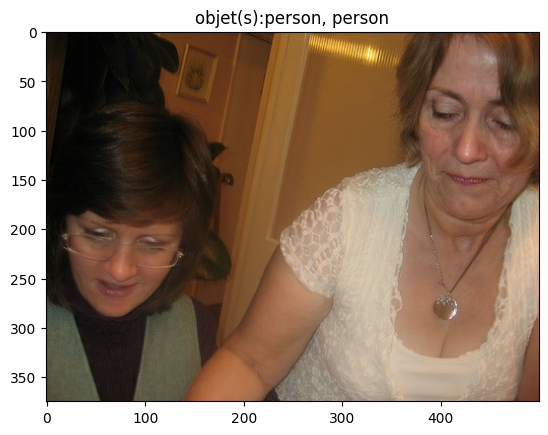

In [5]:
for data in training_dataset.shuffle(len(training_dataset)): #for one img
    print(f"data cléées:{data.keys()}")
    print(f"data.objects cléées:{data['objects'].keys()}, {type(data['objects'].keys())}")
    print(f"data.objects.label:{data['objects']['label']}, {type(data['objects']['label'])}") #returns a tensor listing the labels
    print()
    plt.imshow(data['image'])
    title = "objet(s):"
    for object in data['objects']['label']:
        title += f"{d[object.numpy()]}, "
    plt.title(title[:-2])
    break

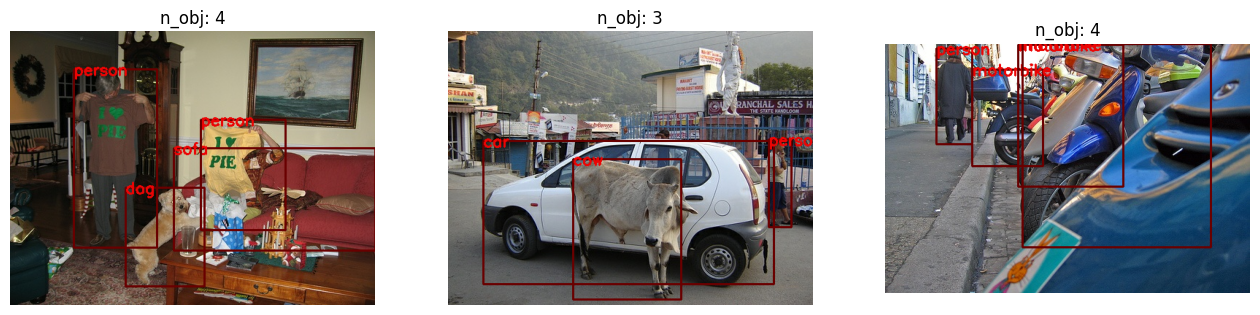

In [6]:
fig = plt.figure(figsize=(16, 10))

for idx, data in enumerate(training_dataset.shuffle(len(training_dataset)).take(3)): #for each 3 images
    fig.add_subplot(1, 3, idx+1)
    img = np.array(data['image'])
    y, x, _ = img.shape
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin, xmin, ymax, xmax = data['objects']['bbox'][idx2].numpy()
        im = cv2.rectangle(img, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(105,0,0), thickness=2) #a rect for each objet
        etiquette = d[objet.numpy()] # add 1 so object corresponds to labels
        cv2.putText(im, etiquette, (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    plt.axis("off")
    plt.title(f"n_obj: {len(data['objects']['label'])}")
    plt.imshow(img)

## We need to create class background if we want to distinguish object from background

In [7]:
roi_pos_l = [] # listes plates
roi_neg_l = []

labels_pos = [] #listes plates
labels_back = []

liste_pos = [] #une liste de listes (matchs par images) sers pour visualiser les matchs
liste_back = [] #une liste de listes (backg par images)

#on fait deux listes de listes : des sous listes par images avec les coord des gt bbox 
#et les coord des predictions pour pouvoir mesurer IoU et determiner si c'est des ROI positives ou negatives

for idx, data in enumerate(tqdm(training_dataset)): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of random rois for one img
    #we need following lists to calculate positives/ negatives
    roi_coord = []
    gt_list_img = []
    
    roi_pos = [] #pr une image quelles sont les roi objets?
    roi_back = []   
    for _, i in roi:
        roi_coord.append(i)
        
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin_n, xmin_n, ymax_n, xmax_n = data['objects']['bbox'][idx2].numpy()
        bbox_gt= convert_label_list(ymin_n*y, xmin_n*x, ymax_n*y, xmax_n*x) #gt coord
        gt_list_img.append(bbox_gt) #une liste de coord pour chaque objet

    pos = matching_boxes(roi_coord, gt_list_img, 0.35)[0] #une liste de matches pour une img
    back = matching_boxes(roi_coord, gt_list_img, 0.35)[1] # liste de 2 roi background pr une img ou une par img
    
    liste_pos.append(pos)
    liste_back.append(back)
    
    
    if len(pos) > 0: #si on a un/+ match
        for j in pos:
            idx_tuple, iou, coord = j
            roi_pos = img.copy()[int(coord[1]-coord[3]/2):int(coord[1]+coord[3]/2),int(coord[0]-coord[2]/2):int(coord[0]+coord[2]/2)]
            roi_pos_l.append(cv2.resize(roi_pos, (224,224)))
            label = data['objects']['label'].numpy()[idx_tuple[1]]
            labels_pos.append(label) #on applatit la structure qui etait nested car les roi sont mtnt les examples
            
    if len(back) > 0: #si on a un background
        for k in back:
            _, _, c = k
            roi_neg = img.copy()[int(c[1]-c[3]/2):int(c[1]+c[3]/2),int(c[0]-c[2]/2):int(c[0]+c[2]/2)]
            roi_neg_l.append(cv2.resize(roi_neg, (224,224)))
            label_b = 20
            labels_back.append(label_b)

100%|██████████████████████████████████████| 2501/2501 [00:12<00:00, 203.45it/s]


In [8]:
d[20] = 'background' #on update le dict

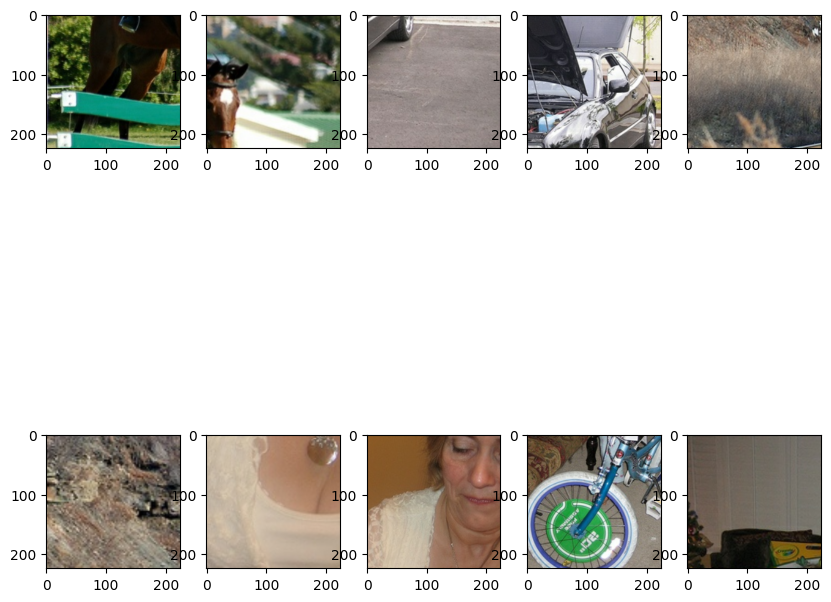

In [9]:
fig = plt.figure(figsize=(10, 10)) #exemples de background
for idx, i in enumerate(roi_neg_l[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(i)
plt.show()

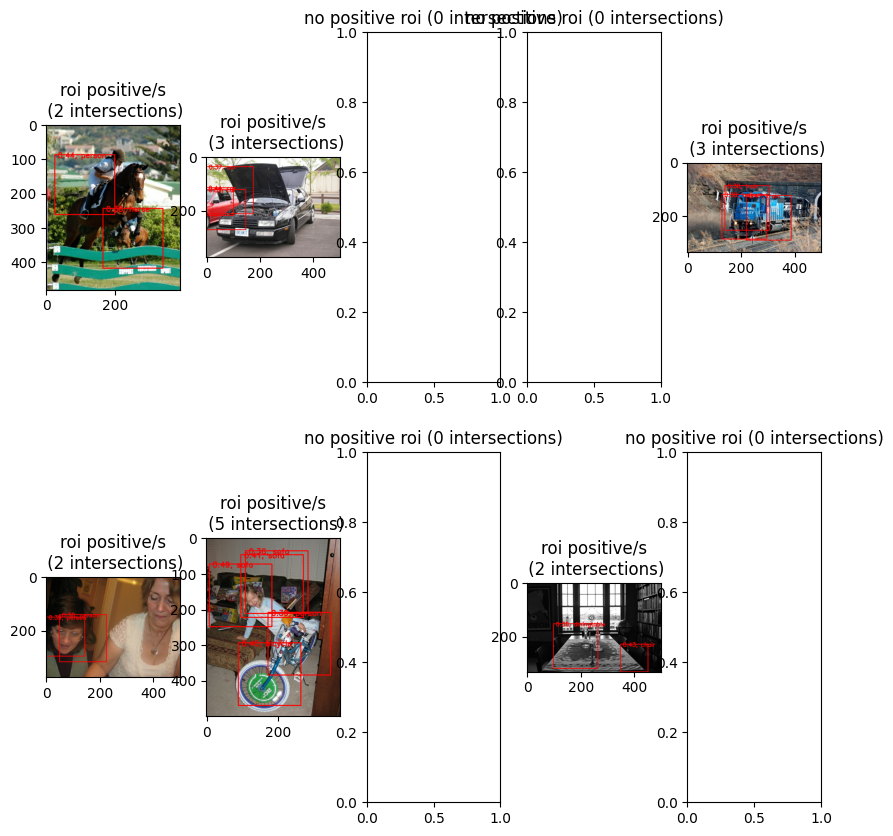

In [10]:
fig = plt.figure(figsize=(10, 10))
for idx, data in enumerate(training_dataset.take(10)):
    fig.add_subplot(2, 5, idx+1)
    copy3 = np.array(data['image']).copy()
    c = 0
    if len(liste_pos[idx]) > 0 :
        for idx2, objet in enumerate(liste_pos[idx]):
            inex, iou, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
            #le deuxieme indice du tuple inex retourne par matching_boxes() etait le rang du label
            cv2.putText(im, f"{iou}, {d[data['objects']['label'].numpy()[inex[1]]]}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
            c += 1
        plt.title(f"roi positive/s\n ({c} intersections)")
        plt.imshow(im)
    else:
        plt.title(f"no positive roi ({c} intersections)")
plt.show()

In [11]:
liste_imgs = roi_pos_l + roi_neg_l
liste_labels = labels_pos + labels_back

In [12]:
d_size = 2048
batch_size = 16

In [13]:
# Identically shuffle the train and test datasets, récupéré d'un TP de RCP 209
if len(liste_imgs) == len(liste_labels):
    p = np.random.permutation(len(liste_imgs))
else:
    print('problem')

for idx, i in enumerate(p):
    liste_imgs[idx] = liste_imgs[i]
    liste_labels[idx] = liste_labels[i]

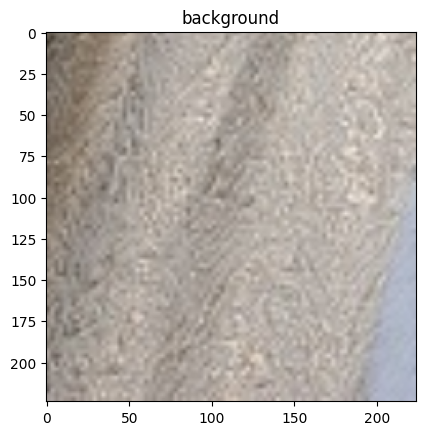

In [14]:
for i, j in zip(liste_imgs, liste_labels):
    plt.imshow(i)
    plt.title(f"{d[j]}")
    break

In [15]:
dataset_i = tf.data.Dataset.from_tensor_slices(np.array(liste_imgs)) #cette ligne cause de freeze du laptop... 
dataset_l = tf.data.Dataset.from_tensor_slices(liste_labels)
ds = tf.data.Dataset.zip((dataset_i, dataset_l))
ds = ds.batch(batch_size) #on ne verifie pas la proportion des images back en relation avec les images d'objets

2024-05-14 18:09:21.026042: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1296798720 exceeds 10% of free system memory.


## On fait le modèle

In [16]:
model = ResNet50(include_top=True, weights='imagenet')
model = Model(inputs=model.input, outputs=model.layers[-2].output) #on retire le classifieur de imagent

## On entrâine le nouveau classifieur apres transfert par initialisation avec ImageNet

In [17]:
fc1 = layers.Dense(32, activation="relu")(model.output)
fc1 = keras.layers.Dropout(0.7)(fc1)
fc2 = Dense(21,activation='softmax')(fc1) #20 classes + back
model = Model(inputs=model.input, outputs=fc2)

for layer in model.layers[:-9]:
    layer.trainable = False
    
#recompile bc we changed the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy' ,
              metrics=['accuracy']
             )

#training
model.load_weights("/home/zuko/environments/projet/poids.weights.h5")
model.fit(ds, epochs=1) 

/home/zuko/environments/projet/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:394: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
2024-05-14 18:09:26.534510: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1296798720 exceeds 10% of free system memory.


539/539 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.6304 - loss: 1.4060


In [18]:
#model.fit(ds, epochs=1) 

In [19]:
model.save_weights("/home/zuko/environments/projet/poids.weights.h5", overwrite=True)

## On a une accuracy > 0.5 en train après 2 epochs avec un ResNet50 pre entrainé sur ImageNet
et dont seules les couches profondes aussi "hautes" ou plus que la dernière couche convolutive (conv5_block3_3_conv)
sont entraînées
on a fit tout le train set, on ne test pas les resultats sur un autre set de données car c'est seulement une étape intermédiaire

## Inférence
on ne cherche pas à détecter le background, ca ne sera pas inclut dans l'analyse car on ressort les pred pour les objets (excl backg) et dont la confiance est suffisemment élevée (arbitrairement défini et bas car on pas entraînné bcp le modèle)
On a pas appris à predire les coordonnées des bbox

In [24]:
liste_detect = [] #une liste de listes 
del idx
for idx, data in enumerate(tqdm(validation_dataset.take(25))): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of random rois for one img
    roi_coord = [] 
    roi_pred = []
    for i, pred_coord in roi: #pr chaque roi predite
        good_pred = []
        pred = model.predict(smart_resize(i,(224,224)).reshape(-1, 224, 224, 3)) #fr une pred pour chaque img
        for idx2, k in enumerate(pred[0]):
            if idx2 != 20 and k > 0.25:
                good_pred.append((pred[0][idx2], idx2, pred_coord))
        #pred_index = int(np.argmax(pred, axis=1))
        #if pred_index != 20: 
            #roi_pred.append((pred_index, pred[0][pred_index]))
        else:
            pass   
    liste_detect.append(good_pred)
    #break

  0%|                                                    | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  4%|█▊                                          | 1/25 [00:02<00:51,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  8%|███▌                                        | 2/25 [00:04<00:47,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 12%|█████▎                                      | 3/25 [00:06<00:44,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 16%|███████                                     | 4/25 [00:08<00:42,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 20%|████████▊                                   | 5/25 [00:10<00:39,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 24%|██████████▌                                 | 6/25 [00:12<00:37,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 28%|████████████▎                               | 7/25 [00:14<00:35,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 32%|██████████████                              | 8/25 [00:15<00:33,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 36%|███████████████▊                            | 9/25 [00:17<00:31,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 40%|█████████████████▏                         | 10/25 [00:19<00:29,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 44%|██████████████████▉                        | 11/25 [00:21<00:27,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 48%|████████████████████▋                      | 12/25 [00:23<00:25,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 52%|██████████████████████▎                    | 13/25 [00:25<00:23,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 56%|████████████████████████                   | 14/25 [00:27<00:21,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 60%|█████████████████████████▊                 | 15/25 [00:29<00:19,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 64%|███████████████████████████▌               | 16/25 [00:31<00:17,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 68%|█████████████████████████████▏             | 17/25 [00:33<00:15,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 72%|██████████████████████████████▉            | 18/25 [00:36<00:14,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 76%|████████████████████████████████▋          | 19/25 [00:38<00:12,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 80%|██████████████████████████████████▍        | 20/25 [00:40<00:11,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 84%|████████████████████████████████████       | 21/25 [00:43<00:08,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 88%|█████████████████████████████████████▊     | 22/25 [00:45<00:06,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 92%|███████████████████████████████████████▌   | 23/25 [00:47<00:04,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 96%|█████████████████████████████████████████▎ | 24/25 [00:49<00:02,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


100%|███████████████████████████████████████████| 25/25 [00:52<00:00,  2.08s/it]


In [25]:
liste_detect

[[(0.25094494, 14, (291.0, 227.0, 175.0, 175.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

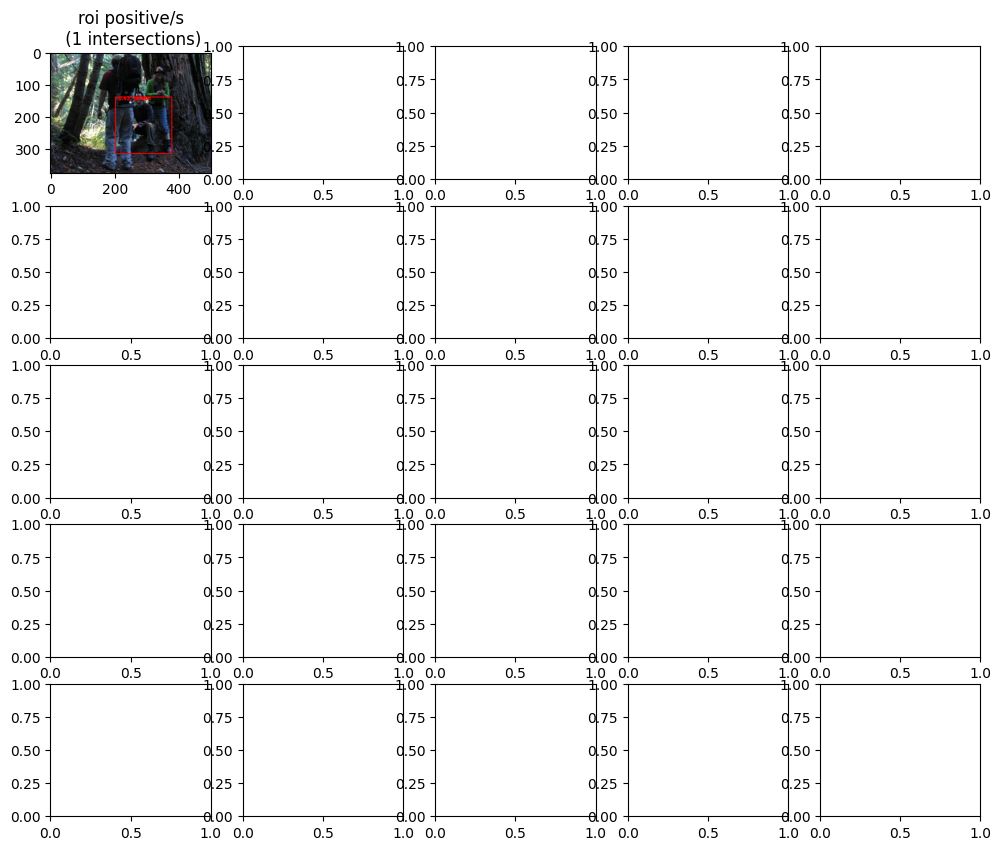

In [27]:
fig = plt.figure(figsize=(12, 10))
for idx, data in enumerate(validation_dataset.take(25)):
    copy3 = np.array(data['image']).copy()
    c = 0
    fig.add_subplot(5, 5, idx+1)
    if len(liste_detect[idx]) > 0 :
        for idx2, detect in enumerate(liste_detect[idx]):
            proba, classe, coord = detect
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
            cv2.putText(im, f"{iou}, {d[classe]}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .5, (235,5,5), 2)
            c += 1
            plt.title(f"roi positive/s\n ({c} intersections)")
            plt.imshow(im)
plt.show()

### Bonus : partie hors sujet mais qu'on avait faîte

In [ ]:
#mettre img qui ont une seule classe d'objet ds une liste
counter = 0
liste_labels = []
liste_imgs = []
for data in tqdm(training_dataset):
    if len(data['labels']) == 1:
        counter +=1
        liste_labels.append(data['labels'][0].numpy())
        liste_imgs.append(smart_resize(data['image'],(224,224)))
print(f"we have :{counter} images with only one class of object/s")
liste_labels[:10], len(liste_labels)

In [ ]:
counter = 0
liste_labels2 = []
liste_imgs2 = []
for data in tqdm(test_dataset):
    if len(data['labels']) == 1:
        counter +=1
        liste_labels2.append(data['labels'][0].numpy())
        liste_imgs2.append(smart_resize(data['image'],(224,224)))
print(f"we have :{counter} images with only one class of object/s")
liste_labels2[:10], len(liste_labels2)

In [ ]:
liste_labels = liste_labels + liste_labels2
liste_imgs = liste_imgs + liste_imgs2

In [ ]:
for idx, (i, j) in enumerate(zip(liste_imgs, liste_labels)):
    plt.imshow(smart_resize(i,(224,224)))
    plt.title(f"{d[j]}")
    break

## On fait le dataset pour pouvoir extraire descripteurs

Cette étape est exporatoire + prépare une alternative à l'entrainnement du *SVM* proposé par **Girschik et. al** dans l'article R-CNN

In [ ]:
d_size = 2048
batch_size = 16

In [ ]:
dataset_i = tf.data.Dataset.from_tensor_slices(liste_imgs)
dataset_l = tf.data.Dataset.from_tensor_slices(liste_labels)
ds = tf.data.Dataset.zip((dataset_i, dataset_l))
ds = ds.batch(batch_size)

In [ ]:
y_train = np.zeros(len(liste_labels), dtype="uint8")
descript = np.zeros((len(liste_labels), d_size), dtype="float32")
y_train.shape, descript.shape

In [ ]:
for idx, (i, j) in enumerate(tqdm(ds)): # cette cellule mets presque 6 min à executer en CPU sur mon laptop
    descript[idx*batch_size:(idx+1)*batch_size] = model.predict(i, verbose=False)
    y_train[idx*batch_size:(idx+1)*batch_size] = j

In [ ]:
output_file = 'deepfeatures_resnet50_voc2007' #on sauve les matrices
np.savez(output_file, X_train=descript, y_train=y_train)
                      #X_test=descript_2, y_test=y_test)

In [ ]:
from sklearn.manifold import TSNE

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
      
tsne = TSNE(n_components=3, perplexity=75, init='random')
embedding = tsne.fit_transform(descript)
scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,-1], c=y_train, marker='o', alpha=0.4)
ax.view_init(elev=15, azim=70)
ax.legend(*scatter.legend_elements())
i = None
for i in np.arange(0, embedding.shape[0], 60):
    ax.text(embedding[i,0], embedding[i,1], embedding[i,2], s=d[y_train[i]])

plt.show()